In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig

from spike_statistics.core import permutation_resampling_test, block_bootstrap

In [22]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation,field_area,theta_score
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.466836,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,69.775141,0.412306,-0.430279
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,62.102729,0.432396,0.307692
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.571614,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,61.189206,0.468221,-0.059705
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.428802,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,4.969741,0.425901,0.132632
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.083406,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000,0.395395,0.218721


In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,orientation,field_area,theta_score,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,69.775141,0.412306,-0.430279,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,62.102729,0.432396,0.307692,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,61.189206,0.468221,-0.059705,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,4.969741,0.425901,0.132632,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.000000,0.395395,0.218721,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# Find all cells with gridness above threshold

In [9]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [10]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [11]:
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [12]:
baseline_i = gridcell_sessions.query('baseline and Hz11 and i')
stimulated_11 = gridcell_sessions.query('frequency==11 and stim_location=="ms"')

baseline_ii = gridcell_sessions.query('baseline and Hz30 and ii')
stimulated_30 = gridcell_sessions.query('frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 51
Number of gridcells in stimulated 30Hz ms sessions 40


# slice unique units

In [13]:
baseline_i = baseline_i.drop_duplicates('unit_id')
stimulated_11 = stimulated_11.drop_duplicates('unit_id')
baseline_ii = baseline_ii.drop_duplicates('unit_id')
stimulated_30 = stimulated_30.drop_duplicates('unit_id')

In [14]:
print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 63
Number of gridcells in stimulated 11Hz ms sessions 58
Number of gridcells in baseline ii sessions 49
Number of gridcells in stimulated 30Hz ms sessions 38


In [23]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11 and stim_location=="ms"', 'baseline and ii and Hz30', 'frequency==30 and stim_location=="ms"']

# Calculate statistics

In [18]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score', 'spacing', 'field_area'
]

In [24]:
results = {}
for key in columns:
    results[key] = list()
    for query, label in zip(queries, labels):
        values = gridcell_sessions.query(query).loc[:,['entity', 'unit_idnum', 'date', key]]
        results[key].append(values.rename({key: label}, axis=1))

In [26]:
from functools import reduce
for key, val in results.items():
    df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
    results[key] = df#.drop('unit_day',axis=1)

In [50]:
results['spacing'].sort_values('entity')

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,0.333416,NaN,0.370479,NaN
106,1833,284,290519,NaN,NaN,0.384464,NaN
104,1833,128,10719,NaN,0.354793,NaN,NaN
103,1833,124,10719,NaN,0.357032,NaN,NaN
102,1833,55,10719,NaN,0.358831,NaN,NaN
...,...,...,...,...,...,...,...
73,1849,724,280219,NaN,0.968465,NaN,0.473208
69,1849,684,220319,NaN,0.522694,NaN,NaN
65,1849,932,280219,0.581307,NaN,NaN,NaN
139,1849,835,150319,NaN,NaN,NaN,0.533441


In [111]:
results['spacing'].drop_duplicates('unit_idnum')

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,0.333416,NaN,0.370479,NaN
1,1833,31,260619,0.368563,NaN,0.362060,0.361666
2,1833,32,260619,0.351924,0.342142,0.355808,0.371447
3,1833,78,260619,0.358140,NaN,NaN,NaN
4,1833,79,260619,0.375787,0.361430,NaN,NaN
...,...,...,...,...,...,...,...
142,1833,274,260619,NaN,NaN,NaN,0.347304
143,1833,275,260619,NaN,NaN,NaN,0.352491
144,1833,248,120619,NaN,NaN,NaN,0.374918
145,1833,249,120619,NaN,NaN,NaN,0.379029


In [114]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [117]:
for key, val in results.items():
    results[key] = drop_duplicates_least_null(val, 'unit_idnum')

In [173]:
bootstrap_results = {}
for key, df in results.items():
    bootstrap_results[key] = pd.DataFrame()
    group = df.groupby('entity')
    for label in labels:
        entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
        if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
        else:
            boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
        bootstrap_results[key].loc[:, label] = np.ravel(boot_samples)

# Create nice table

In [175]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(case - average_control)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)
#     return pval


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [176]:

stat = pd.DataFrame()

for key, df in bootstrap_results.items():
    Key = rename(key)

    for label in labels:
        average, sem, n = compute_weighted_mean_sem(results[key], label)
        if np.isnan(average):
            stat.loc[label, Key] = np.nan
        else:
            stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

    for i, c1 in enumerate(df.columns):
        for c2 in df.columns[i+1:]:
            stat.loc[f'{c1} - {c2}', Key] = pvalue(results[key], df, c1, c2)


In [177]:
stat

,Average rate,Gridness,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,In-field mean rate,Out-field mean rate,Burst event ratio,Specificity,Speed score,Spacing,Field area
Baseline I,9.83 ± 0.93 (63),0.37 ± 0.06 (63),0.66 ± 0.02 (63),5.28 ± 0.43 (63),0.25 ± 0.03 (63),35.83 ± 2.05 (63),1.36 ± 0.09 (63),2.19 ± 0.09 (63),15.29 ± 1.19 (63),7.34 ± 0.79 (63),0.23 ± 0.01 (63),0.42 ± 0.03 (63),0.11 ± 0.01 (63),0.56 ± 0.02 (63),0.45 ± 0.01 (63)
11 Hz,10.96 ± 1.03 (56),0.40 ± 0.05 (56),0.71 ± 0.03 (56),5.42 ± 0.59 (56),0.22 ± 0.04 (56),35.78 ± 2.21 (56),0.93 ± 0.07 (56),2.01 ± 0.14 (56),15.79 ± 1.29 (56),8.76 ± 0.90 (56),0.23 ± 0.01 (56),0.39 ± 0.04 (56),0.09 ± 0.01 (56),0.54 ± 0.02 (56),0.43 ± 0.01 (56)
Baseline II,10.44 ± 1.00 (46),0.53 ± 0.04 (46),0.66 ± 0.03 (46),6.24 ± 0.67 (46),0.23 ± 0.03 (46),42.21 ± 2.43 (46),1.27 ± 0.10 (46),2.16 ± 0.08 (46),16.81 ± 1.23 (46),7.76 ± 0.86 (46),0.23 ± 0.01 (46),0.43 ± 0.03 (46),0.09 ± 0.01 (46),0.52 ± 0.02 (46),0.44 ± 0.01 (46)
30 Hz,8.50 ± 1.12 (35),0.57 ± 0.05 (35),0.64 ± 0.04 (35),6.75 ± 0.67 (35),0.24 ± 0.04 (35),36.96 ± 2.53 (35),1.14 ± 0.11 (35),2.27 ± 0.11 (35),13.14 ± 1.26 (35),5.97 ± 0.87 (35),0.18 ± 0.01 (35),0.47 ± 0.04 (35),0.07 ± 0.01 (35),0.49 ± 0.01 (35),0.44 ± 0.01 (35)
Baseline I - 11 Hz,"4.2e-01 [-1.10, 4.15]","7.4e-01 [-0.21, 0.20]","3.3e-01 [-0.06, 0.14]","8.4e-01 [-1.68, 1.66]","6.9e-01 [-0.15, 0.09]","9.8e-01 [-7.75, 6.63]","0.0e+00 [-0.69, -0.12]","4.8e-01 [-0.65, 0.40]","8.7e-01 [-2.87, 4.11]","4.0e-01 [-1.91, 4.19]","8.2e-01 [-0.03, 0.03]","7.3e-01 [-0.14, 0.09]","5.7e-01 [-0.06, 0.02]","7.0e-01 [-0.12, 0.08]","3.5e-01 [-0.04, 0.01]"
Baseline I - Baseline II,"7.8e-01 [-3.53, 5.28]","2.0e-02 [-0.00, 0.29]","1.0e+00 [-0.15, 0.13]","4.4e-01 [-1.51, 3.50]","7.4e-01 [-0.15, 0.11]","9.0e-02 [-0.45, 13.33]","6.8e-01 [-0.39, 0.46]","8.9e-01 [-0.41, 0.33]","5.0e-01 [-1.96, 6.58]","8.4e-01 [-2.45, 3.49]","8.0e-01 [-0.03, 0.04]","8.2e-01 [-0.09, 0.13]","4.0e-01 [-0.06, 0.01]","5.4e-01 [-0.12, 0.05]","6.3e-01 [-0.03, 0.03]"
Baseline I - 30 Hz,"5.2e-01 [-5.65, 2.78]","0.0e+00 [0.02, 0.38]","7.6e-01 [-0.14, 0.10]","3.4e-01 [-0.41, 4.65]","8.4e-01 [-0.15, 0.12]","8.3e-01 [-6.64, 10.59]","3.9e-01 [-0.64, 0.27]","6.2e-01 [-0.30, 0.52]","4.3e-01 [-5.96, 4.30]","4.7e-01 [-4.34, 2.06]","3.0e-02 [-0.09, -0.00]","5.7e-01 [-0.07, 0.21]","9.0e-02 [-0.07, 0.01]","5.0e-02 [-0.13, 0.01]","8.7e-01 [-0.04, 0.04]"
11 Hz - Baseline II,"8.2e-01 [-4.66, 4.15]","1.7e-01 [-0.03, 0.26]","3.6e-01 [-0.20, 0.07]","4.9e-01 [-1.65, 3.35]","8.4e-01 [-0.12, 0.15]","8.0e-02 [-0.41, 13.38]","8.0e-02 [0.04, 0.89]","4.7e-01 [-0.23, 0.51]","6.2e-01 [-2.46, 6.08]","5.5e-01 [-3.88, 2.06]","8.8e-01 [-0.04, 0.04]","4.8e-01 [-0.06, 0.16]","7.2e-01 [-0.05, 0.03]","8.1e-01 [-0.10, 0.07]","7.1e-01 [-0.02, 0.04]"
11 Hz - 30 Hz,"3.0e-01 [-6.79, 1.64]","8.0e-02 [-0.02, 0.34]","2.7e-01 [-0.19, 0.05]","3.8e-01 [-0.55, 4.50]","7.1e-01 [-0.11, 0.15]","8.2e-01 [-6.59, 10.63]","4.4e-01 [-0.21, 0.71]","2.5e-01 [-0.12, 0.70]","3.3e-01 [-6.46, 3.80]","9.0e-02 [-5.76, 0.63]","2.0e-02 [-0.09, -0.01]","3.1e-01 [-0.04, 0.24]","3.5e-01 [-0.06, 0.02]","2.1e-01 [-0.11, 0.04]","6.9e-01 [-0.02, 0.05]"
Baseline II - 30 Hz,"4.0e-01 [-6.26, 2.17]","6.5e-01 [-0.14, 0.22]","7.8e-01 [-0.13, 0.10]","7.0e-01 [-1.37, 3.68]","8.6e-01 [-0.13, 0.14]","3.0e-01 [-13.03, 4.20]","7.0e-01 [-0.55, 0.37]","5.8e-01 [-0.27, 0.55]","1.3e-01 [-7.48, 2.79]","3.0e-01 [-4.76, 1.64]","1.0e-02 [-0.10, -0.01]","6.8e-01 [-0.09, 0.20]","5.3e-01 [-0.05, 0.02]","3.4e-01 [-0.10, 0.05]","8.7e-01 [-0.03, 0.05]"


In [141]:
stat.to_latex(output_path / "statistics" / f"statistics.tex")
stat.to_csv(output_path / "statistics" / f"statistics.csv")

In [142]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}".format(statistic, pvalue)
#     return pvalue

def summarize_paired(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()

    return dff[keys[0]].mean(), dff[keys[0]].sem(), dff[keys[1]].mean(), dff[keys[1]].sem(), len(dff)


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)


In [144]:
paired_stat = pd.DataFrame()

for key, df in results.items():
    Key = rename(key)
        
    for i, c1 in enumerate(labels):
        for c2 in labels[i+1:]:
            m1, s1, m2, s2, n = summarize_paired(df, [c1, c2])
            paired_stat.loc[f'{c1}', Key] = "{:.2f} ± {:.2f} ({})".format(m1, s1, n)
            paired_stat.loc[f'{c2}', Key] = "{:.2f} ± {:.2f} ({})".format(m2, s2, n)
            
    for label in labels:
        paired_stat.loc[f'Normality {label}', Key] = normality(df, label)
        
    for i, c1 in enumerate(labels):
        for c2 in labels[i+1:]:
#             paired_stat.loc[f'{c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
            paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
#             paired_stat.loc[f'MWU {c1} - {c2}', Key] = MWU(df, [c1, c2])

paired_stat

,Average rate,Gridness,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,In-field mean rate,Out-field mean rate,Burst event ratio,Specificity,Speed score,Spacing,Field area
Baseline I,8.01 ± 2.48 (8),0.72 ± 0.10 (8),0.57 ± 0.09 (8),6.91 ± 1.44 (8),0.27 ± 0.07 (8),35.36 ± 3.42 (8),1.22 ± 0.15 (8),2.48 ± 0.25 (8),13.86 ± 2.79 (8),5.77 ± 2.15 (8),0.21 ± 0.03 (8),0.56 ± 0.11 (8),0.15 ± 0.02 (8),0.41 ± 0.03 (8),0.46 ± 0.02 (8)
11 Hz,8.09 ± 1.84 (10),0.40 ± 0.18 (10),0.65 ± 0.07 (10),5.44 ± 1.06 (10),0.20 ± 0.05 (10),29.80 ± 4.01 (10),0.87 ± 0.14 (10),2.24 ± 0.20 (10),12.21 ± 2.17 (10),5.71 ± 1.60 (10),0.21 ± 0.03 (10),0.49 ± 0.08 (10),0.06 ± 0.03 (10),0.49 ± 0.06 (10),0.43 ± 0.02 (10)
Baseline II,6.72 ± 1.11 (16),0.60 ± 0.08 (16),0.54 ± 0.05 (16),7.10 ± 0.98 (16),0.30 ± 0.05 (16),36.20 ± 2.28 (16),1.33 ± 0.14 (16),2.72 ± 0.17 (16),12.60 ± 1.18 (16),4.26 ± 0.94 (16),0.20 ± 0.02 (16),0.58 ± 0.06 (16),0.10 ± 0.01 (16),0.41 ± 0.02 (16),0.45 ± 0.02 (16)
30 Hz,6.99 ± 1.41 (16),0.45 ± 0.11 (16),0.58 ± 0.06 (16),6.93 ± 0.87 (16),0.27 ± 0.05 (16),33.55 ± 2.85 (16),1.10 ± 0.13 (16),2.42 ± 0.17 (16),11.65 ± 1.53 (16),4.63 ± 1.19 (16),0.16 ± 0.01 (16),0.55 ± 0.06 (16),0.09 ± 0.02 (16),0.41 ± 0.02 (16),0.44 ± 0.01 (16)
Normality Baseline I,"7.10, 2.9e-02","13.02, 1.5e-03","6.63, 3.6e-02","18.26, 1.1e-04","43.58, 3.4e-10","3.47, 1.8e-01","6.15, 4.6e-02","35.35, 2.1e-08","6.23, 4.4e-02","9.49, 8.7e-03","1.59, 4.5e-01","7.29, 2.6e-02","4.32, 1.2e-01","30.27, 2.7e-07","6.15, 4.6e-02"
Normality 11 Hz,"5.12, 7.7e-02","0.51, 7.7e-01","5.86, 5.3e-02","29.74, 3.5e-07","55.49, 8.9e-13","0.60, 7.4e-01","25.74, 2.6e-06","45.62, 1.2e-10","4.57, 1.0e-01","6.46, 3.9e-02","1.17, 5.6e-01","5.51, 6.4e-02","2.31, 3.2e-01","33.45, 5.4e-08","18.67, 8.8e-05"
Normality Baseline II,"8.68, 1.3e-02","4.92, 8.5e-02","5.48, 6.5e-02","28.18, 7.6e-07","17.17, 1.9e-04","7.97, 1.9e-02","13.13, 1.4e-03","3.01, 2.2e-01","4.07, 1.3e-01","15.52, 4.3e-04","1.51, 4.7e-01","3.01, 2.2e-01","8.93, 1.2e-02","25.68, 2.7e-06","10.17, 6.2e-03"
Normality 30 Hz,"8.12, 1.7e-02","1.47, 4.8e-01","8.06, 1.8e-02","3.42, 1.8e-01","9.65, 8.0e-03","0.77, 6.8e-01","9.19, 1.0e-02","1.78, 4.1e-01","5.04, 8.0e-02","9.37, 9.2e-03","1.23, 5.4e-01","4.51, 1.0e-01","27.88, 8.8e-07","9.84, 7.3e-03","2.49, 2.9e-01"
Wilcoxon Baseline I - 11 Hz,"61.00, 5.8e-02","92.00, 4.1e-01","48.00, 1.9e-02","94.00, 4.5e-01","34.00, 4.6e-03","79.00, 2.0e-01","16.00, 5.4e-04","63.00, 6.8e-02","54.00, 3.3e-02","77.00, 1.8e-01","99.00, 5.7e-01","31.00, 3.3e-03","71.00, 1.2e-01","82.00, 2.4e-01","56.00, 3.9e-02"
Wilcoxon Baseline I - Baseline II,"49.00, 5.3e-01","44.00, 3.6e-01","41.00, 2.8e-01","44.00, 3.6e-01","43.00, 3.3e-01","34.00, 1.4e-01","57.00, 8.6e-01","35.00, 1.6e-01","41.00, 2.8e-01","40.00, 2.6e-01","48.00, 5.0e-01","33.00, 1.3e-01","45.00, 3.9e-01","54.00, 7.3e-01","23.00, 3.6e-02"


In [145]:
paired_stat.to_latex(output_path / "statistics" / f"paired-statistics.tex")
paired_stat.to_csv(output_path / "statistics" / f"paired-statistics.csv")

In [146]:
for key, result in results.items():
    result.to_latex(output_path / "statistics" / f"values_{key}.tex")
    result.to_csv(output_path / "statistics" / f"values_{key}.csv")

# Violinplot

In [147]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

# Information rate

In [149]:
def violinplot(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmedians=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6, 1.2, 1.7999999999999998]


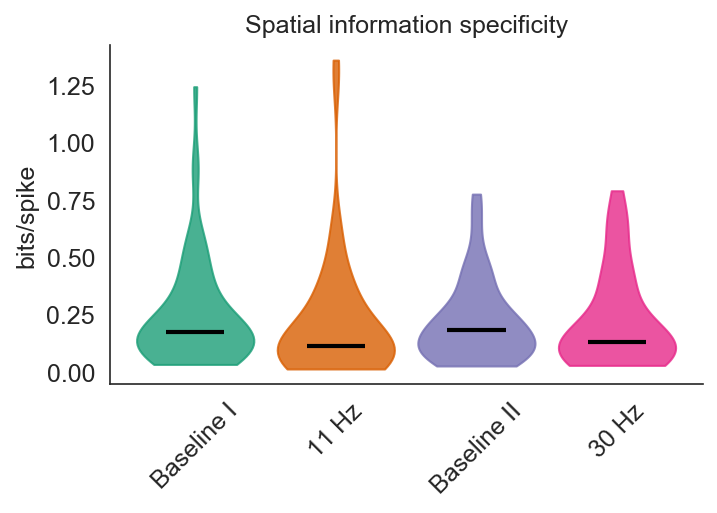

In [150]:
violinplot([results['information_specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Spatial information specificity")
plt.ylabel("bits/spike")
# plt.ylim(-0.2, 1.6)

savefig(output_path / "figures" / "information_specificity")

[0.0, 0.6, 1.2, 1.7999999999999998]


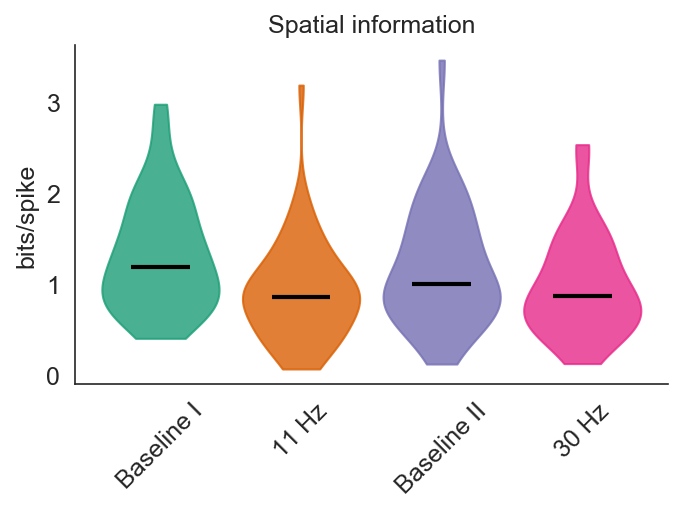

In [151]:
violinplot([results['information_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Spatial information")
plt.ylabel("bits/spike")

savefig(output_path / "figures" / "spatial_information")

[0.0, 0.6, 1.2, 1.7999999999999998]


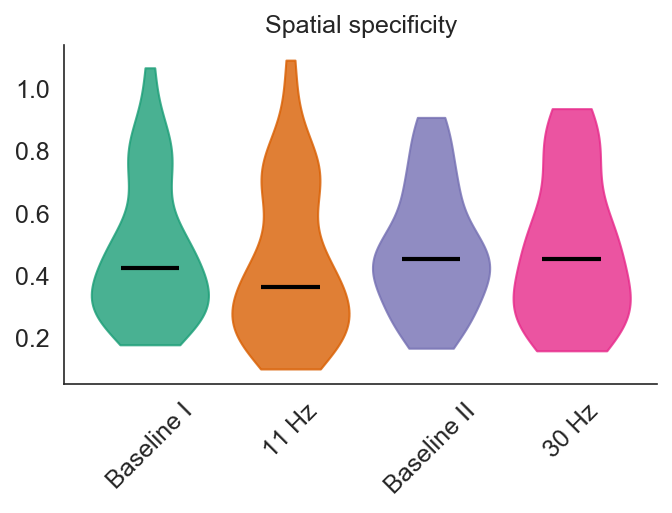

In [152]:
violinplot([results['specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Spatial specificity")
plt.ylabel("")

savefig(output_path / "figures" / "specificity")

[0.0, 0.6, 1.2, 1.7999999999999998]


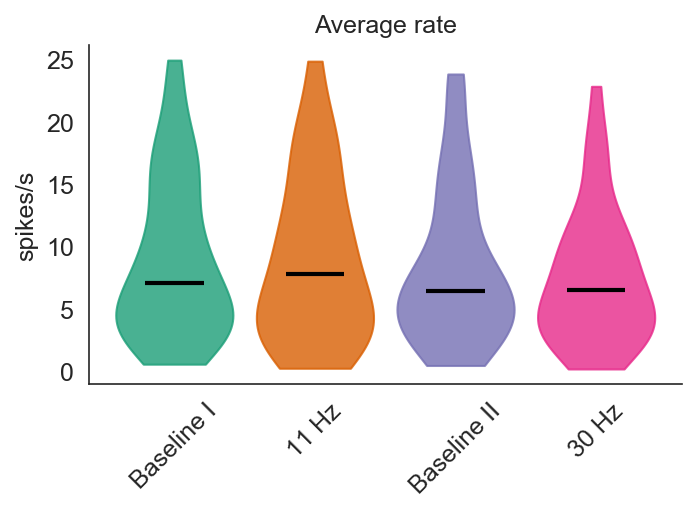

In [153]:
violinplot([results['average_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Average rate")
plt.ylabel("spikes/s")

savefig(output_path / "figures" / "average_rate")

[0.0, 0.6, 1.2, 1.7999999999999998]


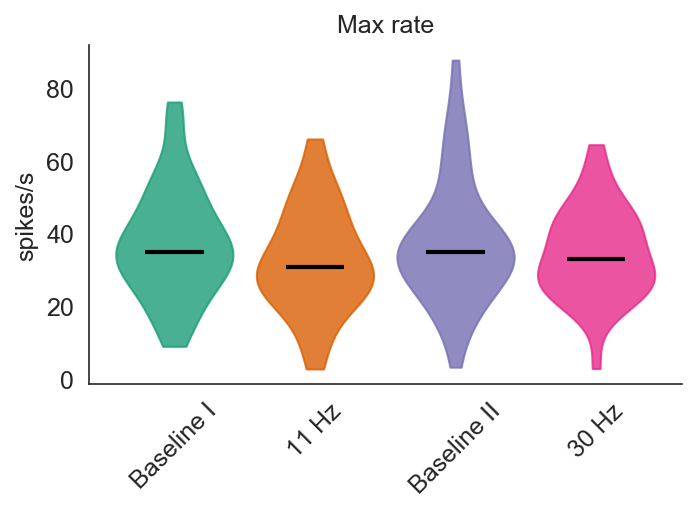

In [154]:
violinplot([results['max_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Max rate")
plt.ylabel("spikes/s")

savefig(output_path / "figures" / "max_rate")

[0.0, 0.6, 1.2, 1.7999999999999998]


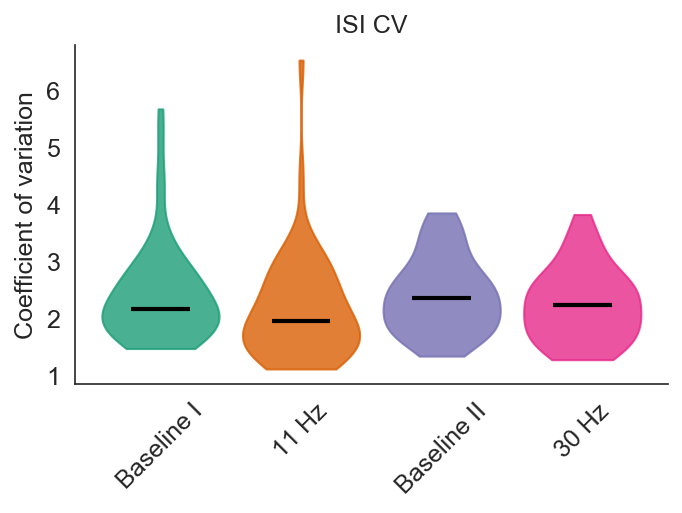

In [155]:
violinplot([results['interspike_interval_cv'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("ISI CV")
plt.ylabel("Coefficient of variation")

savefig(output_path / "figures" / "isi_cv")

[0.0, 0.6, 1.2, 1.7999999999999998]


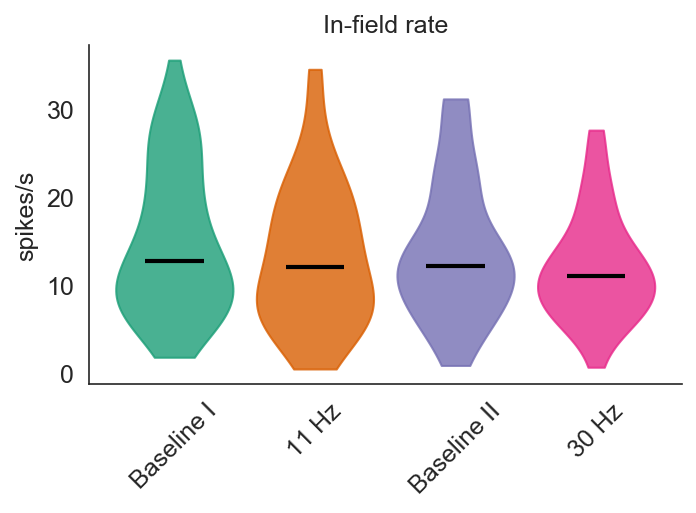

In [156]:
violinplot([results['in_field_mean_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("In-field rate")
plt.ylabel("spikes/s")

savefig(output_path / "figures" / "in_field_mean_rate")

[0.0, 0.6, 1.2, 1.7999999999999998]


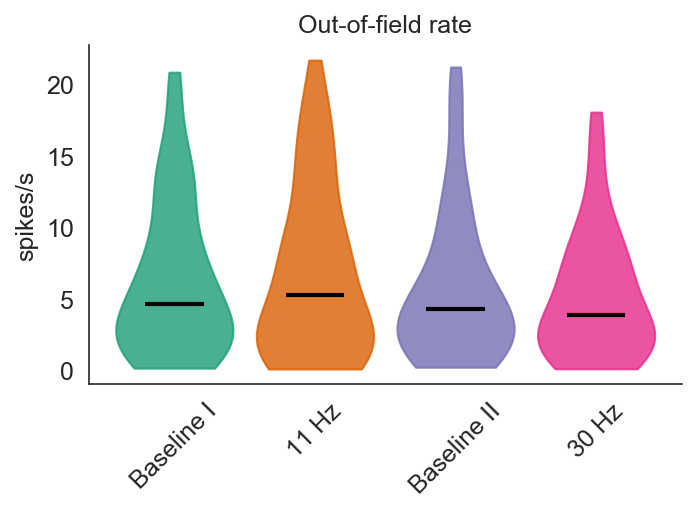

In [157]:
violinplot([results['out_field_mean_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Out-of-field rate")
plt.ylabel("spikes/s")

savefig(output_path / "figures" / "out_field_mean_rate")

[0.0, 0.6, 1.2, 1.7999999999999998]


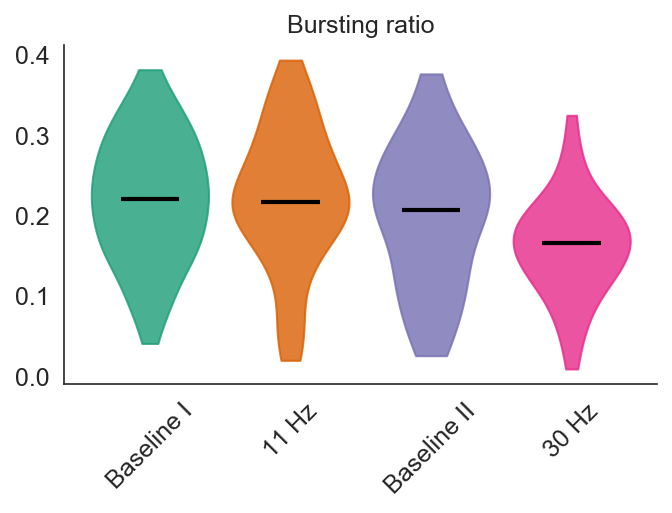

In [158]:
violinplot([results['burst_event_ratio'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Bursting ratio")
plt.ylabel("")

savefig(output_path / "figures" / "burst_event_ratio")

[0.0, 0.6, 1.2, 1.7999999999999998]


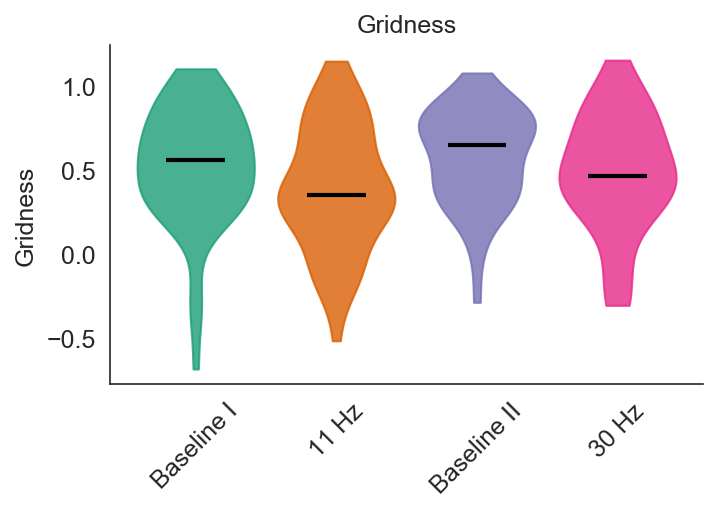

In [159]:
violinplot([results['gridness'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Gridness")
plt.ylabel("Gridness")

savefig(output_path / "figures" / "gridness")

[0.0, 0.6, 1.2, 1.7999999999999998]


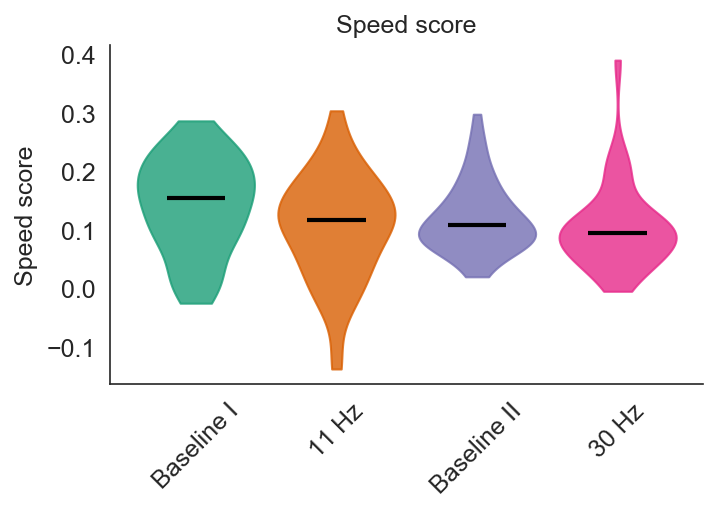

In [160]:
violinplot([results['speed_score'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
plt.title("Speed score")
plt.ylabel("Speed score")

savefig(output_path / "figures" / "speed_score")

# Register in Expipe

In [43]:
action = project.require_action("comparisons-gridcells")

In [44]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_b_i_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gr

In [45]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_gridcells.ipynb")